In [19]:
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import itertools
import matplotlib.pyplot as plt 

from torch_geometric.data import Data
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.nn import Linear

In [2]:
# load in data (GNPC supplementary table 5)
file_path = 'gnpc_supp.xlsx'
sheet_name = 'SuppTbl5'
df = pd.read_excel(file_path, sheet_name=sheet_name, header=1)

In [3]:
# select only the columns we need for training/prediction
col_for_training = ['EntrezGeneSymbol', 'Avg_StdBeta_weighted_AD', 'Meta_p_weighted_AD', 'Avg_StdBeta_weighted_PD', 'Meta_p_weighted_PD',
                    'Avg_StdBeta_weighted_FTD', 'Meta_p_weighted_FTD', 'StdBeta_ALS', 'p_ALS'] 

features_df = df[col_for_training].copy() # avoids SettingWithCopyWarning warning in next cell
features_df.rename(columns={'EntrezGeneSymbol' : 'EntrezGeneSymbol', 'Avg_StdBeta_weighted_AD' : 'AD_beta', 
                            'Meta_p_weighted_AD' : 'AD_p', 'Avg_StdBeta_weighted_PD' : 'PD_beta', 'Meta_p_weighted_PD' : 'PD_p',
                            'Avg_StdBeta_weighted_FTD' : 'FTD_beta', 'Meta_p_weighted_FTD' : 'FTD_p', 'StdBeta_ALS': 'ALS_beta', 'p_ALS' : 'ALS_p'
                            }, inplace=True)# rename cols for easier access  
features_df.head()

,EntrezGeneSymbol,AD_beta,AD_p,PD_beta,PD_p,FTD_beta,FTD_p,ALS_beta,ALS_p
0,CRYBB2,0.020411,0.105892,-0.019541,0.002026,0.016847,0.126806,-0.075116,0.201204
1,RAF1,-0.018095,0.863149,0.004977,0.189185,0.007533,0.393355,-0.052058,0.369734
2,ZNF41,0.049706,0.000772,0.004067,0.466674,0.000385,0.385409,0.015578,0.790375
3,ELK1,0.028990,0.002776,0.010033,0.580357,0.000471,0.457739,0.088028,0.129374
4,GUCA1A,-0.014837,0.151340,-0.006160,0.018256,-0.054077,0.095542,0.030428,0.603799


In [4]:
# data cleaning
# remove NAs & fill with zero, keep only the first duplicate for genes with multiple entries

print(f"Shape before: {features_df.shape}")
features_df.drop_duplicates(subset='EntrezGeneSymbol', keep='first', inplace=True)
features_df.set_index('EntrezGeneSymbol', inplace=True)
features_df.fillna(0, inplace=True)
print(f"Shape after: {features_df.shape}")

Shape before: (7289, 9)
Shape after: (6386, 8)


In [6]:
# feature engineering
# p values could really skew our overall data distribution, so we will -log transform them

# small value added to prevent log(0)
epsilon = 1e-8

# create the -log10(p-value) features
p_value_cols = ['AD_p', 'PD_p', 'FTD_p', 'ALS_p']
for col in p_value_cols:
    new_col_name = col.replace('_p', '_logp')
    features_df[new_col_name] = -np.log10(features_df[col] + epsilon)

# create feature matrix
final_features = [
    'AD_beta', 'AD_logp',
    'PD_beta', 'PD_logp',
    'FTD_beta', 'FTD_logp',
    'ALS_beta', 'ALS_p'
]

# filter out old p value cols
final_features_df = features_df[final_features]
final_features_df.head()

,AD_beta,AD_logp,PD_beta,PD_logp,FTD_beta,FTD_logp,ALS_beta,ALS_p
EntrezGeneSymbol,,,,,,,,
CRYBB2,0.020411,0.975136,-0.019541,2.693365,0.016847,0.896860,-0.075116,0.201204
RAF1,-0.018095,0.063914,0.004977,0.723114,0.007533,0.405216,-0.052058,0.369734
ZNF41,0.049706,3.112230,0.004067,0.330987,0.000385,0.414078,0.015578,0.790375
ELK1,0.028990,2.556574,0.010033,0.236305,0.000471,0.339382,0.088028,0.129374
GUCA1A,-0.014837,0.820047,-0.006160,1.738601,-0.054077,1.019804,0.030428,0.603799


In [7]:
# get the PPI graph edges to use for the edge_weights and edge_index tensors
edges = pd.read_csv("ppi_edges_raw.csv")

# get edge indices as np array
edge_indices_np = edges[['src', 'dst']].values

# transpose array so it's in correct format for torch_geometric (2 x num_edges)
edge_indices_transposed = edge_indices_np.transpose()

edges.head()

,src,dst,weight,combined_score
0,0,904,0.952953,952.0
1,0,1878,0.888889,888.0
2,0,4898,0.862863,862.0
3,0,1629,0.861862,861.0
4,0,5307,0.842843,842.0


In [8]:
# Generate torch_geometric.data.data Data object

scaler = StandardScaler() # we need to scale our beta values

# create X
X_scaled = scaler.fit_transform(final_features_df.values)
X = torch.tensor(X_scaled, dtype=torch.float)

# create Y - we're predicting beta values for all 4 diseases
y_df = features_df[['AD_beta', 'PD_beta', 'FTD_beta', 'ALS_beta']] 
y_scaled = scaler.fit_transform(y_df.values)
Y = torch.tensor(y_scaled, dtype=torch.float)

# create edge index tensor
edge_index = torch.tensor(edge_indices_transposed, dtype = torch.long)

# create edge weight tensor
edge_weights = torch.tensor(edges['weight'].values, dtype=torch.float)


# create training, validation, and testing masks (60/20/20 split)
N = final_features_df.shape[0]
split_labels = np.random.choice([0, 1, 2], N, p = [0.6, 0.2, 0.2]) # 0 is train, 1 is val, 2 is test

train_mask = torch.tensor(split_labels==0, dtype=torch.bool)
val_mask = torch.tensor(split_labels==1, dtype=torch.bool)
test_mask = torch.tensor(split_labels==2, dtype=torch.bool)

# create data object
graph_data = Data(
    x=X,
    edge_index=edge_index,
    edge_weights=edge_weights,
    y=Y,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask
)
graph_data

Data(x=[6386, 8], edge_index=[2, 80102], y=[6386, 4], edge_weights=[80102], train_mask=[6386], val_mask=[6386], test_mask=[6386])

In [9]:
def get_loss_weights(df):
    '''
    Calculates weights for loss function terms based on inverse variance of beta values.

    Parameters
    ----------
    df : Pandas DataFrame that includes the columns "AD_beta", "PD_beta", "FTD_beta", "ALS_beta"

    Returns
    -------
    ad_wt, pd_wt, ftd_wt, als_wt : weights for each component of the combined loss function
    '''

    betas = df[["AD_beta", "PD_beta", "FTD_beta", "ALS_beta"]]

    # get variance of beta values for each disease 
    variances_by_disease = betas.var()

    # calculate inverse variance to use as weight
    inverse_variances = 1/variances_by_disease.values

    # normalize weights so they add up to 1
    normalized_wts = inverse_variances / inverse_variances.sum()

    ad_wt, pd_wt, ftd_wt, als_wt = normalized_wts

    return ad_wt, pd_wt, ftd_wt, als_wt

AD_wt = get_loss_weights(final_features_df)[0]
PD_wt = get_loss_weights(final_features_df)[1]
FTD_wt = get_loss_weights(final_features_df)[2]
ALS_wt = get_loss_weights(final_features_df)[3]

Epoch 000 | Train: 1.0117 | Val: 1.0317 * NEW BEST
Epoch 010 | Train: 0.9257 | Val: 0.9415 * NEW BEST
Epoch 020 | Train: 0.8335 | Val: 0.8406 * NEW BEST
Epoch 030 | Train: 0.7590 | Val: 0.7590 * NEW BEST
Epoch 040 | Train: 0.7168 | Val: 0.7110 * NEW BEST
Epoch 050 | Train: 0.6919 | Val: 0.6874 * NEW BEST
Epoch 060 | Train: 0.6810 | Val: 0.6776 * NEW BEST
Epoch 070 | Train: 0.6730 | Val: 0.6708 * NEW BEST
Epoch 080 | Train: 0.6677 | Val: 0.6641 * NEW BEST
Epoch 090 | Train: 0.6630 | Val: 0.6590 * NEW BEST
Epoch 100 | Train: 0.6577 | Val: 0.6549 * NEW BEST
Epoch 110 | Train: 0.6547 | Val: 0.6507 * NEW BEST
Epoch 120 | Train: 0.6504 | Val: 0.6471 * NEW BEST
Epoch 130 | Train: 0.6461 | Val: 0.6433 * NEW BEST
Epoch 140 | Train: 0.6432 | Val: 0.6400 * NEW BEST
Epoch 150 | Train: 0.6400 | Val: 0.6367 * NEW BEST
Epoch 160 | Train: 0.6358 | Val: 0.6327 * NEW BEST
Epoch 170 | Train: 0.6325 | Val: 0.6299 * NEW BEST
Epoch 180 | Train: 0.6308 | Val: 0.6262 * NEW BEST
Epoch 190 | Train: 0.6263 | Val

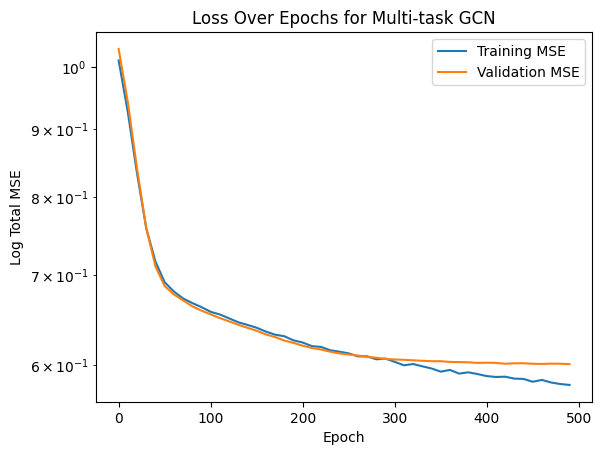

(0.5806915760040283, tensor(0.6013, device='cuda:0'))

In [25]:
# model - 2 layer GCN  with 4 outputs (regression for beta prediction for each disease)
class My_GCN(torch.nn.Module):
    
    def __init__(self, num_features, n_neurons, dropout):
        '''
        Initializes an instances of the My_GCN class.

        Parameters
        ----------
        num_features : int
            Number of features in the feature tensor (X).
        n_neurons : int
            Number of dimensions in the space that input features are transformed to.
        dropout : float
            Percentage that determines how many neurons are ignored during a foward/backward pass.

        '''
        super(My_GCN, self).__init__()
        
        self.dropout = dropout

        self.conv1 = GCNConv(num_features, n_neurons)
        self.conv2 = GCNConv(n_neurons, n_neurons)

        # linear layers for beta prediction for each disease
        self.out_ad = Linear(n_neurons, 1) 
        self.out_pd = Linear(n_neurons, 1) 
        self.out_ftd = Linear(n_neurons, 1)  
        self.out_als = Linear(n_neurons, 1) 

    def forward(self, data):
        '''
        Forward pass for the 2-layer GCN. 

        Parameters
        ----------
        data : Pandas DataFrame
            Includes beta values and p-values for each disease.

        Returns
        -------
        AD_pred, PD_pred, FTD_pred, ALS_pred : Pytorch tensors
            Beta predictions for each disease.
        '''        
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weights

        x1 = self.conv1(x, edge_index, edge_weight)
        x2 = F.relu(x1)
        x3 = F.dropout(x2, p=self.dropout, training=self.training)

        x4 = self.conv2(x3, edge_index, edge_weight)
        x5 = F.relu(x4)

        # get predictions for each disease, removing dimension of 1
        AD_pred = self.out_ad(x5).squeeze(1)
        PD_pred = self.out_pd(x5).squeeze(1)
        FTD_pred = self.out_ftd(x5).squeeze(1)
        ALS_pred = self.out_als(x5).squeeze(1)
        
        return AD_pred, PD_pred, FTD_pred, ALS_pred

class FitModel():
    
    def __init__(self, my_model, learning_rate: float = 0.01):
        
        # Adam for optimization
        self.optimizer = torch.optim.Adam(my_model.parameters(), lr = learning_rate)
        self.model = my_model

    def get_MSE(self, data, mask):
        ''' 
        Calculates MSE for each disease beta prediction.
        
        Parameters
        ----------
        data : Pandas DataFrame
            Includes beta values and p-values for each disease.

        mask : NumPy array
            Proteins (nodes) used for either training, validation, or testing.

        Returns
        -------
        MSE_ad, MSE_pd, MSE_ftd, MSE_als : float
            MSE values for each disease beta prediction.
        '''

        out1, out2, out3, out4 = self.model(data)

        # calculate MSE for each disease beta prediction
        MSE_ad = F.mse_loss(out1[mask], data.y[mask, 0])
        MSE_pd = F.mse_loss(out2[mask], data.y[mask, 1])
        MSE_ftd = F.mse_loss(out3[mask], data.y[mask, 2])
        MSE_als = F.mse_loss(out4[mask], data.y[mask, 3])

        return MSE_ad, MSE_pd, MSE_ftd, MSE_als
        
    def run(self, data, N_epochs: int = 500):
        '''
        Runs the training loop, validation, and testing on the best model identified by validation loss.

        Parameters
        ----------
        data : Pandas DataFrame
            Includes beta values and p-values for each disease.

        N_epochs : int
            Number of times to run the training loop. 

        Returns
        -------
        total_loss : float
            Total loss for the final epoch.
        best_val_loss : float
            Best validation loss found over N_epochs.
        '''
        best_val_loss = float('inf')

        # intialize lists so we can plot MSE over epochs
        train_losses = []
        val_losses = []
        epoch_nums = []
        
        for n in range(N_epochs):
            
            self.model.train() # set model to training mode (learning is occurring)
            self.optimizer.zero_grad()
            
            # get MSE for each disease
            ad_loss, pd_loss, ftd_loss, als_loss = self.get_MSE(data, data.train_mask)

            total_loss = AD_wt*ad_loss + PD_wt*pd_loss + FTD_wt*ftd_loss + ALS_wt*als_loss
            total_loss.backward()
            
            self.optimizer.step()

            if n % 10 == 0:
                # validation loss
                self.model.eval() # pause learning
                with torch.no_grad():
                    ad_MSE_val, pd_MSE_val, ftd_MSE_val, als_MSE_val = self.get_MSE(data, data.val_mask)
                    total_val_loss = AD_wt*ad_MSE_val + PD_wt*pd_MSE_val + FTD_wt*ftd_MSE_val + ALS_wt*als_MSE_val

                    # add losses & current epoch to lists
                    train_losses.append(total_loss.item())
                    val_losses.append(total_val_loss.item())
                    epoch_nums.append(n)
                
                # compare current loss to best loss
                if total_val_loss.item() < best_val_loss:
                    best_val_loss = total_val_loss

                    # save best model
                    torch.save(self.model.state_dict(), 'best_model.pth')

                    print(f"Epoch {n:03d} | Train: {total_loss.item():.4f} | Val: {total_val_loss.item():.4f} * NEW BEST")
                else:
                    print(f"Epoch {n:03d} | Train: {total_loss.item():.4f} | Val: {total_val_loss.item():.4f}")

        # testing loss
        # get best model
        self.model.load_state_dict(torch.load('best_model.pth'))

        self.model.eval()
        with torch.no_grad():
            ad_MSE_test, pd_MSE_test, ftd_MSE_test, als_MSE_test = self.get_MSE(data, data.test_mask)
            total_test_loss = AD_wt*ad_MSE_test + PD_wt*pd_MSE_test + FTD_wt*ftd_MSE_test + ALS_wt*als_MSE_test

        print(f"Best val loss: {best_val_loss}")   
        print(f"Test loss for best model: {total_test_loss}")

        # plot train and val mse over epochs
        self.plot(train_losses, val_losses, epoch_nums)

        return total_loss.item(), best_val_loss
    
    def hp_tuning(self, data, num_features):
        '''Performs hyperparameter tuning for the GCN by iterating through combinations of learning rate, number of neurons, and dropout rate.
        
        Parameters
        ----------
        data : Pandas DataFrame
            Includes beta values and p-values for each disease.

        num_features : int
            Number of features in the feature tensor (X).

        Returns
        -------
        best_params : dictonary
            Combination of parameters that produced the lowest validation loss.
        '''

        # define parameter space (learning rate, dropout rate, n_neurons)

        param_grid = {
            'learning_rate' : [0.001, 0.0001, 0.00001], 
            'n_neurons' : [64, 128],
            'dropout_rate' : [0.3, 0.6]
            }

        best_loss = float('inf') # initialize with value of +infinity
        best_params = None

        for lr, n_neurons, dr in itertools.product(param_grid['learning_rate'], param_grid['n_neurons'], param_grid['dropout_rate']):

            model = My_GCN(num_features=num_features, n_neurons=n_neurons, dropout=dr)
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = model.to(device)

            hp_tuner = FitModel(model, learning_rate=lr)
            losses = hp_tuner.run(data, N_epochs=500)
            current_loss_t = losses[1]
            current_loss = current_loss_t.item()

            if current_loss < best_loss:
                best_loss = current_loss
                best_params = {'lr' : lr, 'n_neurons' : n_neurons, 'dr' : dr}
        print(f'Best params: {best_params}')
        print(f'Best val loss: {best_loss}')

        return best_params
    
    def plot(self, train_losses, val_losses, epoch_nums):
        '''
        Plots MSE loss over epochs for training and validation.

        Parameters
        ----------
        train_losses : list
            List containing training losses for all epochs.
        val_losses : list
            List containing validation losses for all epochs.
        epoch_nums : list
            List containing epoch numbers. 
        '''

        plt.figure()
        plt.plot(epoch_nums, train_losses, label = 'Training MSE')
        plt.plot(epoch_nums, val_losses, label = 'Validation MSE')

        plt.title("Loss Over Epochs for Multi-task GCN")
        plt.xlabel("Epoch")
        plt.ylabel("Log Total MSE")
        plt.yscale("log")
        plt.legend()
        plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_model = My_GCN(num_features=X.shape[1], n_neurons=128, dropout=0.3) # parameters determined through hyperparameter search
my_model = my_model.to(device)
graph_data = graph_data.to(device)
My_Fit = FitModel(my_model, 0.001)
My_Fit.run(graph_data)

Epoch 000 | Train: 0.9996 | Val: 1.0249 * NEW BEST
Epoch 010 | Train: 0.9542 | Val: 0.9760 * NEW BEST
Epoch 020 | Train: 0.9019 | Val: 0.9197 * NEW BEST
Epoch 030 | Train: 0.8448 | Val: 0.8544 * NEW BEST
Epoch 040 | Train: 0.7906 | Val: 0.7934 * NEW BEST
Epoch 050 | Train: 0.7541 | Val: 0.7510 * NEW BEST
Epoch 060 | Train: 0.7304 | Val: 0.7208 * NEW BEST
Epoch 070 | Train: 0.7100 | Val: 0.6988 * NEW BEST
Epoch 080 | Train: 0.6986 | Val: 0.6838 * NEW BEST
Epoch 090 | Train: 0.6896 | Val: 0.6747 * NEW BEST
Epoch 100 | Train: 0.6823 | Val: 0.6689 * NEW BEST
Epoch 110 | Train: 0.6749 | Val: 0.6642 * NEW BEST
Epoch 120 | Train: 0.6738 | Val: 0.6600 * NEW BEST
Epoch 130 | Train: 0.6677 | Val: 0.6563 * NEW BEST
Epoch 140 | Train: 0.6653 | Val: 0.6532 * NEW BEST
Epoch 150 | Train: 0.6640 | Val: 0.6500 * NEW BEST
Epoch 160 | Train: 0.6597 | Val: 0.6469 * NEW BEST
Epoch 170 | Train: 0.6559 | Val: 0.6445 * NEW BEST
Epoch 180 | Train: 0.6524 | Val: 0.6415 * NEW BEST
Epoch 190 | Train: 0.6503 | Val

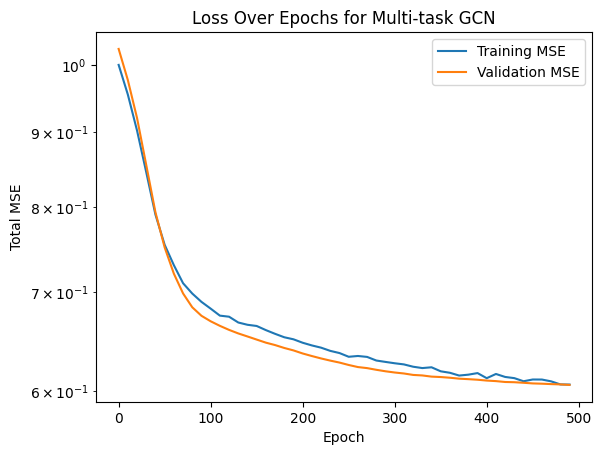

Epoch 000 | Train: 1.0191 | Val: 1.0380 * NEW BEST
Epoch 010 | Train: 0.9782 | Val: 0.9961 * NEW BEST
Epoch 020 | Train: 0.9367 | Val: 0.9520 * NEW BEST
Epoch 030 | Train: 0.8899 | Val: 0.8966 * NEW BEST
Epoch 040 | Train: 0.8424 | Val: 0.8344 * NEW BEST
Epoch 050 | Train: 0.7991 | Val: 0.7822 * NEW BEST
Epoch 060 | Train: 0.7677 | Val: 0.7458 * NEW BEST
Epoch 070 | Train: 0.7530 | Val: 0.7213 * NEW BEST
Epoch 080 | Train: 0.7430 | Val: 0.7037 * NEW BEST
Epoch 090 | Train: 0.7300 | Val: 0.6914 * NEW BEST
Epoch 100 | Train: 0.7148 | Val: 0.6826 * NEW BEST
Epoch 110 | Train: 0.7201 | Val: 0.6765 * NEW BEST
Epoch 120 | Train: 0.7087 | Val: 0.6719 * NEW BEST
Epoch 130 | Train: 0.7045 | Val: 0.6680 * NEW BEST
Epoch 140 | Train: 0.7024 | Val: 0.6641 * NEW BEST
Epoch 150 | Train: 0.6968 | Val: 0.6616 * NEW BEST
Epoch 160 | Train: 0.6907 | Val: 0.6585 * NEW BEST
Epoch 170 | Train: 0.6890 | Val: 0.6558 * NEW BEST
Epoch 180 | Train: 0.6855 | Val: 0.6528 * NEW BEST
Epoch 190 | Train: 0.6835 | Val

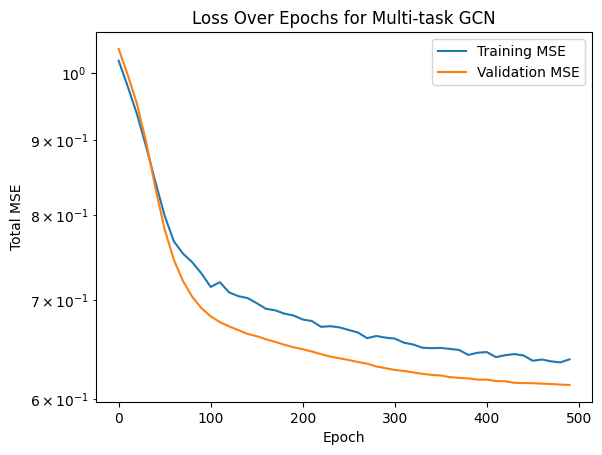

Epoch 000 | Train: 1.0087 | Val: 1.0274 * NEW BEST
Epoch 010 | Train: 0.9324 | Val: 0.9480 * NEW BEST
Epoch 020 | Train: 0.8385 | Val: 0.8451 * NEW BEST
Epoch 030 | Train: 0.7596 | Val: 0.7573 * NEW BEST
Epoch 040 | Train: 0.7155 | Val: 0.7108 * NEW BEST
Epoch 050 | Train: 0.6911 | Val: 0.6914 * NEW BEST
Epoch 060 | Train: 0.6829 | Val: 0.6811 * NEW BEST
Epoch 070 | Train: 0.6744 | Val: 0.6734 * NEW BEST
Epoch 080 | Train: 0.6691 | Val: 0.6663 * NEW BEST
Epoch 090 | Train: 0.6642 | Val: 0.6603 * NEW BEST
Epoch 100 | Train: 0.6574 | Val: 0.6561 * NEW BEST
Epoch 110 | Train: 0.6539 | Val: 0.6524 * NEW BEST
Epoch 120 | Train: 0.6496 | Val: 0.6479 * NEW BEST
Epoch 130 | Train: 0.6469 | Val: 0.6443 * NEW BEST
Epoch 140 | Train: 0.6429 | Val: 0.6403 * NEW BEST
Epoch 150 | Train: 0.6407 | Val: 0.6371 * NEW BEST
Epoch 160 | Train: 0.6360 | Val: 0.6333 * NEW BEST
Epoch 170 | Train: 0.6335 | Val: 0.6301 * NEW BEST
Epoch 180 | Train: 0.6285 | Val: 0.6263 * NEW BEST
Epoch 190 | Train: 0.6260 | Val

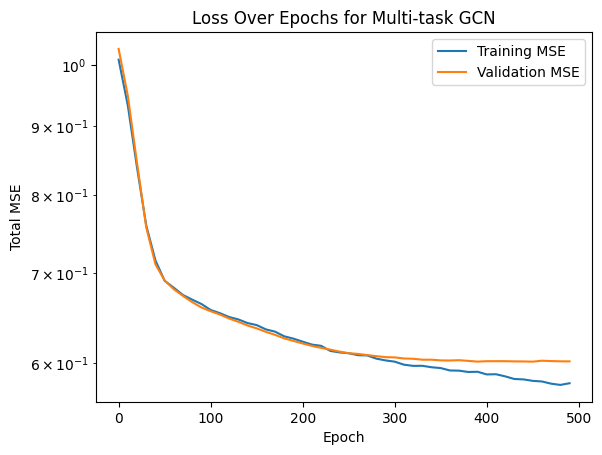

Epoch 000 | Train: 1.0126 | Val: 1.0328 * NEW BEST
Epoch 010 | Train: 0.9320 | Val: 0.9440 * NEW BEST
Epoch 020 | Train: 0.8471 | Val: 0.8446 * NEW BEST
Epoch 030 | Train: 0.7765 | Val: 0.7652 * NEW BEST
Epoch 040 | Train: 0.7442 | Val: 0.7204 * NEW BEST
Epoch 050 | Train: 0.7163 | Val: 0.6974 * NEW BEST
Epoch 060 | Train: 0.7052 | Val: 0.6825 * NEW BEST
Epoch 070 | Train: 0.6960 | Val: 0.6746 * NEW BEST
Epoch 080 | Train: 0.6868 | Val: 0.6691 * NEW BEST
Epoch 090 | Train: 0.6800 | Val: 0.6631 * NEW BEST
Epoch 100 | Train: 0.6782 | Val: 0.6590 * NEW BEST
Epoch 110 | Train: 0.6735 | Val: 0.6555 * NEW BEST
Epoch 120 | Train: 0.6689 | Val: 0.6520 * NEW BEST
Epoch 130 | Train: 0.6665 | Val: 0.6486 * NEW BEST
Epoch 140 | Train: 0.6630 | Val: 0.6454 * NEW BEST
Epoch 150 | Train: 0.6597 | Val: 0.6413 * NEW BEST
Epoch 160 | Train: 0.6564 | Val: 0.6385 * NEW BEST
Epoch 170 | Train: 0.6510 | Val: 0.6345 * NEW BEST
Epoch 180 | Train: 0.6511 | Val: 0.6314 * NEW BEST
Epoch 190 | Train: 0.6456 | Val

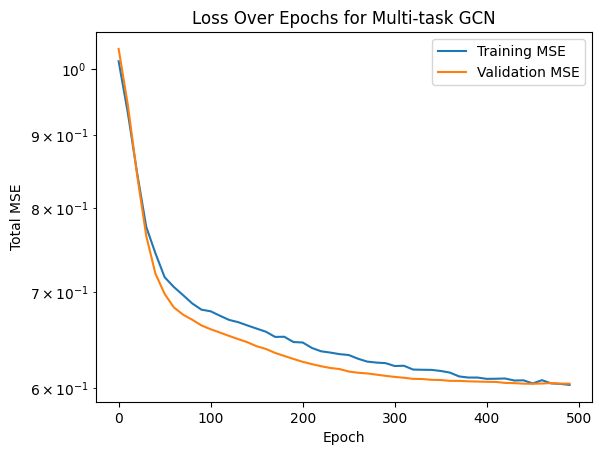

Epoch 000 | Train: 1.0018 | Val: 1.0299 * NEW BEST
Epoch 010 | Train: 0.9978 | Val: 1.0254 * NEW BEST
Epoch 020 | Train: 0.9946 | Val: 1.0210 * NEW BEST
Epoch 030 | Train: 0.9895 | Val: 1.0166 * NEW BEST
Epoch 040 | Train: 0.9854 | Val: 1.0122 * NEW BEST
Epoch 050 | Train: 0.9811 | Val: 1.0077 * NEW BEST
Epoch 060 | Train: 0.9766 | Val: 1.0031 * NEW BEST
Epoch 070 | Train: 0.9720 | Val: 0.9983 * NEW BEST
Epoch 080 | Train: 0.9683 | Val: 0.9935 * NEW BEST
Epoch 090 | Train: 0.9636 | Val: 0.9884 * NEW BEST
Epoch 100 | Train: 0.9580 | Val: 0.9831 * NEW BEST
Epoch 110 | Train: 0.9539 | Val: 0.9776 * NEW BEST
Epoch 120 | Train: 0.9491 | Val: 0.9718 * NEW BEST
Epoch 130 | Train: 0.9431 | Val: 0.9658 * NEW BEST
Epoch 140 | Train: 0.9368 | Val: 0.9595 * NEW BEST
Epoch 150 | Train: 0.9318 | Val: 0.9531 * NEW BEST
Epoch 160 | Train: 0.9242 | Val: 0.9464 * NEW BEST
Epoch 170 | Train: 0.9195 | Val: 0.9394 * NEW BEST
Epoch 180 | Train: 0.9138 | Val: 0.9323 * NEW BEST
Epoch 190 | Train: 0.9063 | Val

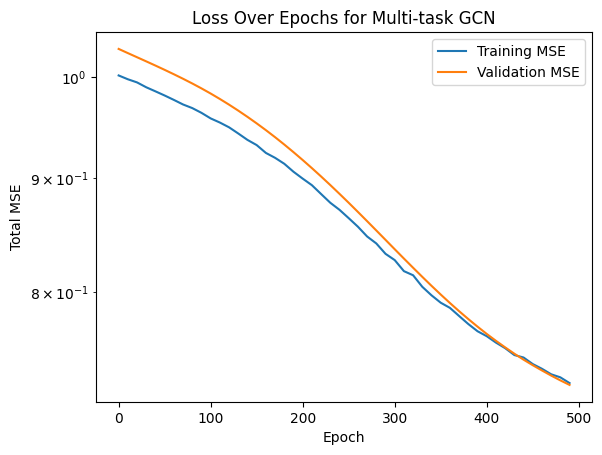

Epoch 000 | Train: 0.9967 | Val: 1.0176 * NEW BEST
Epoch 010 | Train: 0.9906 | Val: 1.0125 * NEW BEST
Epoch 020 | Train: 0.9867 | Val: 1.0074 * NEW BEST
Epoch 030 | Train: 0.9847 | Val: 1.0022 * NEW BEST
Epoch 040 | Train: 0.9775 | Val: 0.9970 * NEW BEST
Epoch 050 | Train: 0.9721 | Val: 0.9918 * NEW BEST
Epoch 060 | Train: 0.9646 | Val: 0.9863 * NEW BEST
Epoch 070 | Train: 0.9654 | Val: 0.9807 * NEW BEST
Epoch 080 | Train: 0.9612 | Val: 0.9750 * NEW BEST
Epoch 090 | Train: 0.9508 | Val: 0.9690 * NEW BEST
Epoch 100 | Train: 0.9466 | Val: 0.9629 * NEW BEST
Epoch 110 | Train: 0.9407 | Val: 0.9565 * NEW BEST
Epoch 120 | Train: 0.9364 | Val: 0.9500 * NEW BEST
Epoch 130 | Train: 0.9309 | Val: 0.9433 * NEW BEST
Epoch 140 | Train: 0.9213 | Val: 0.9364 * NEW BEST
Epoch 150 | Train: 0.9168 | Val: 0.9294 * NEW BEST
Epoch 160 | Train: 0.9115 | Val: 0.9222 * NEW BEST
Epoch 170 | Train: 0.9050 | Val: 0.9149 * NEW BEST
Epoch 180 | Train: 0.8992 | Val: 0.9075 * NEW BEST
Epoch 190 | Train: 0.8933 | Val

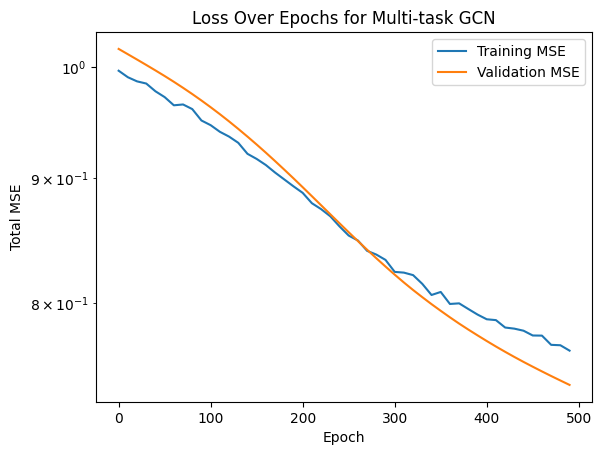

Epoch 000 | Train: 0.9991 | Val: 1.0266 * NEW BEST
Epoch 010 | Train: 0.9898 | Val: 1.0171 * NEW BEST
Epoch 020 | Train: 0.9810 | Val: 1.0078 * NEW BEST
Epoch 030 | Train: 0.9723 | Val: 0.9984 * NEW BEST
Epoch 040 | Train: 0.9639 | Val: 0.9888 * NEW BEST
Epoch 050 | Train: 0.9537 | Val: 0.9788 * NEW BEST
Epoch 060 | Train: 0.9443 | Val: 0.9683 * NEW BEST
Epoch 070 | Train: 0.9330 | Val: 0.9572 * NEW BEST
Epoch 080 | Train: 0.9221 | Val: 0.9455 * NEW BEST
Epoch 090 | Train: 0.9110 | Val: 0.9332 * NEW BEST
Epoch 100 | Train: 0.8993 | Val: 0.9203 * NEW BEST
Epoch 110 | Train: 0.8867 | Val: 0.9069 * NEW BEST
Epoch 120 | Train: 0.8742 | Val: 0.8933 * NEW BEST
Epoch 130 | Train: 0.8622 | Val: 0.8794 * NEW BEST
Epoch 140 | Train: 0.8490 | Val: 0.8655 * NEW BEST
Epoch 150 | Train: 0.8365 | Val: 0.8518 * NEW BEST
Epoch 160 | Train: 0.8230 | Val: 0.8384 * NEW BEST
Epoch 170 | Train: 0.8119 | Val: 0.8254 * NEW BEST
Epoch 180 | Train: 0.8008 | Val: 0.8131 * NEW BEST
Epoch 190 | Train: 0.7893 | Val

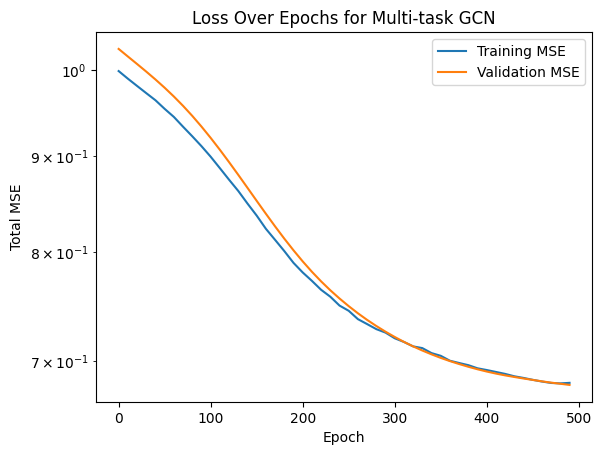

Epoch 000 | Train: 1.0156 | Val: 1.0443 * NEW BEST
Epoch 010 | Train: 1.0080 | Val: 1.0341 * NEW BEST
Epoch 020 | Train: 0.9992 | Val: 1.0243 * NEW BEST
Epoch 030 | Train: 0.9897 | Val: 1.0145 * NEW BEST
Epoch 040 | Train: 0.9791 | Val: 1.0047 * NEW BEST
Epoch 050 | Train: 0.9687 | Val: 0.9947 * NEW BEST
Epoch 060 | Train: 0.9613 | Val: 0.9845 * NEW BEST
Epoch 070 | Train: 0.9524 | Val: 0.9739 * NEW BEST
Epoch 080 | Train: 0.9430 | Val: 0.9628 * NEW BEST
Epoch 090 | Train: 0.9303 | Val: 0.9512 * NEW BEST
Epoch 100 | Train: 0.9220 | Val: 0.9391 * NEW BEST
Epoch 110 | Train: 0.9110 | Val: 0.9266 * NEW BEST
Epoch 120 | Train: 0.8995 | Val: 0.9136 * NEW BEST
Epoch 130 | Train: 0.8898 | Val: 0.9003 * NEW BEST
Epoch 140 | Train: 0.8746 | Val: 0.8869 * NEW BEST
Epoch 150 | Train: 0.8643 | Val: 0.8735 * NEW BEST
Epoch 160 | Train: 0.8495 | Val: 0.8603 * NEW BEST
Epoch 170 | Train: 0.8425 | Val: 0.8475 * NEW BEST
Epoch 180 | Train: 0.8302 | Val: 0.8353 * NEW BEST
Epoch 190 | Train: 0.8207 | Val

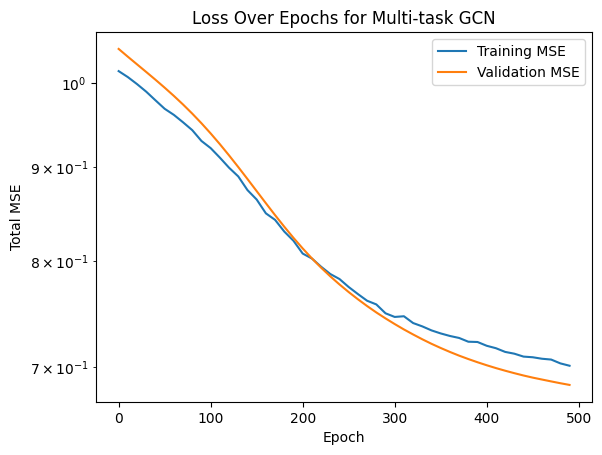

Epoch 000 | Train: 1.0133 | Val: 1.0409 * NEW BEST
Epoch 010 | Train: 1.0126 | Val: 1.0402 * NEW BEST
Epoch 020 | Train: 1.0105 | Val: 1.0395 * NEW BEST
Epoch 030 | Train: 1.0102 | Val: 1.0389 * NEW BEST
Epoch 040 | Train: 1.0095 | Val: 1.0382 * NEW BEST
Epoch 050 | Train: 1.0088 | Val: 1.0376 * NEW BEST
Epoch 060 | Train: 1.0084 | Val: 1.0369 * NEW BEST
Epoch 070 | Train: 1.0065 | Val: 1.0363 * NEW BEST
Epoch 080 | Train: 1.0092 | Val: 1.0356 * NEW BEST
Epoch 090 | Train: 1.0051 | Val: 1.0350 * NEW BEST
Epoch 100 | Train: 1.0079 | Val: 1.0343 * NEW BEST
Epoch 110 | Train: 1.0047 | Val: 1.0337 * NEW BEST
Epoch 120 | Train: 1.0056 | Val: 1.0330 * NEW BEST
Epoch 130 | Train: 1.0040 | Val: 1.0324 * NEW BEST
Epoch 140 | Train: 1.0043 | Val: 1.0317 * NEW BEST
Epoch 150 | Train: 1.0029 | Val: 1.0311 * NEW BEST
Epoch 160 | Train: 1.0037 | Val: 1.0305 * NEW BEST
Epoch 170 | Train: 1.0016 | Val: 1.0298 * NEW BEST
Epoch 180 | Train: 1.0010 | Val: 1.0292 * NEW BEST
Epoch 190 | Train: 1.0002 | Val

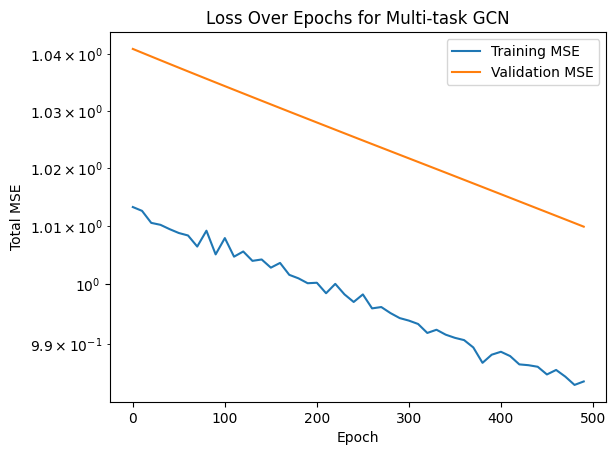

Epoch 000 | Train: 1.0286 | Val: 1.0565 * NEW BEST
Epoch 010 | Train: 1.0286 | Val: 1.0560 * NEW BEST
Epoch 020 | Train: 1.0270 | Val: 1.0555 * NEW BEST
Epoch 030 | Train: 1.0284 | Val: 1.0549 * NEW BEST
Epoch 040 | Train: 1.0259 | Val: 1.0544 * NEW BEST
Epoch 050 | Train: 1.0278 | Val: 1.0539 * NEW BEST
Epoch 060 | Train: 1.0272 | Val: 1.0533 * NEW BEST
Epoch 070 | Train: 1.0250 | Val: 1.0528 * NEW BEST
Epoch 080 | Train: 1.0248 | Val: 1.0523 * NEW BEST
Epoch 090 | Train: 1.0259 | Val: 1.0517 * NEW BEST
Epoch 100 | Train: 1.0266 | Val: 1.0512 * NEW BEST
Epoch 110 | Train: 1.0219 | Val: 1.0507 * NEW BEST
Epoch 120 | Train: 1.0219 | Val: 1.0502 * NEW BEST
Epoch 130 | Train: 1.0209 | Val: 1.0497 * NEW BEST
Epoch 140 | Train: 1.0238 | Val: 1.0492 * NEW BEST
Epoch 150 | Train: 1.0207 | Val: 1.0486 * NEW BEST
Epoch 160 | Train: 1.0209 | Val: 1.0481 * NEW BEST
Epoch 170 | Train: 1.0211 | Val: 1.0476 * NEW BEST
Epoch 180 | Train: 1.0203 | Val: 1.0471 * NEW BEST
Epoch 190 | Train: 1.0212 | Val

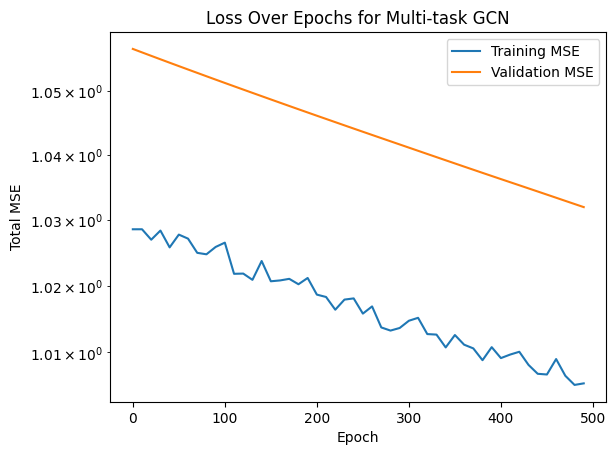

Epoch 000 | Train: 1.0029 | Val: 1.0300 * NEW BEST
Epoch 010 | Train: 1.0019 | Val: 1.0290 * NEW BEST
Epoch 020 | Train: 1.0006 | Val: 1.0281 * NEW BEST
Epoch 030 | Train: 1.0000 | Val: 1.0271 * NEW BEST
Epoch 040 | Train: 0.9995 | Val: 1.0262 * NEW BEST
Epoch 050 | Train: 0.9979 | Val: 1.0253 * NEW BEST
Epoch 060 | Train: 0.9968 | Val: 1.0243 * NEW BEST
Epoch 070 | Train: 0.9959 | Val: 1.0234 * NEW BEST
Epoch 080 | Train: 0.9954 | Val: 1.0225 * NEW BEST
Epoch 090 | Train: 0.9942 | Val: 1.0215 * NEW BEST
Epoch 100 | Train: 0.9932 | Val: 1.0206 * NEW BEST
Epoch 110 | Train: 0.9930 | Val: 1.0197 * NEW BEST
Epoch 120 | Train: 0.9919 | Val: 1.0187 * NEW BEST
Epoch 130 | Train: 0.9908 | Val: 1.0178 * NEW BEST
Epoch 140 | Train: 0.9900 | Val: 1.0169 * NEW BEST
Epoch 150 | Train: 0.9887 | Val: 1.0159 * NEW BEST
Epoch 160 | Train: 0.9882 | Val: 1.0150 * NEW BEST
Epoch 170 | Train: 0.9875 | Val: 1.0141 * NEW BEST
Epoch 180 | Train: 0.9863 | Val: 1.0131 * NEW BEST
Epoch 190 | Train: 0.9853 | Val

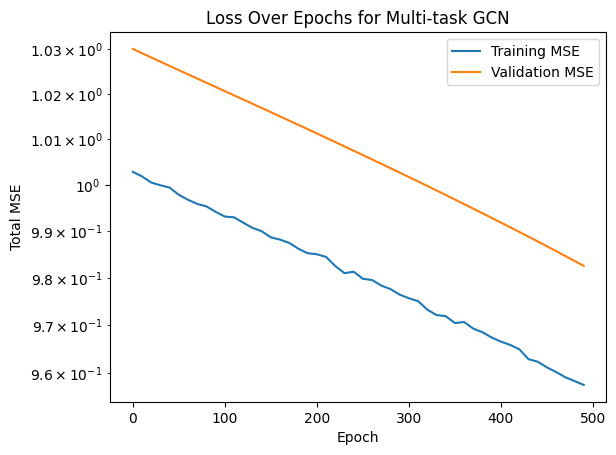

Epoch 000 | Train: 1.0185 | Val: 1.0440 * NEW BEST
Epoch 010 | Train: 1.0166 | Val: 1.0430 * NEW BEST
Epoch 020 | Train: 1.0140 | Val: 1.0420 * NEW BEST
Epoch 030 | Train: 1.0143 | Val: 1.0411 * NEW BEST
Epoch 040 | Train: 1.0140 | Val: 1.0401 * NEW BEST
Epoch 050 | Train: 1.0114 | Val: 1.0392 * NEW BEST
Epoch 060 | Train: 1.0109 | Val: 1.0382 * NEW BEST
Epoch 070 | Train: 1.0132 | Val: 1.0373 * NEW BEST
Epoch 080 | Train: 1.0100 | Val: 1.0363 * NEW BEST
Epoch 090 | Train: 1.0088 | Val: 1.0354 * NEW BEST
Epoch 100 | Train: 1.0079 | Val: 1.0344 * NEW BEST
Epoch 110 | Train: 1.0067 | Val: 1.0335 * NEW BEST
Epoch 120 | Train: 1.0061 | Val: 1.0326 * NEW BEST
Epoch 130 | Train: 1.0060 | Val: 1.0316 * NEW BEST
Epoch 140 | Train: 1.0057 | Val: 1.0307 * NEW BEST
Epoch 150 | Train: 1.0034 | Val: 1.0298 * NEW BEST
Epoch 160 | Train: 1.0015 | Val: 1.0289 * NEW BEST
Epoch 170 | Train: 1.0007 | Val: 1.0279 * NEW BEST
Epoch 180 | Train: 1.0028 | Val: 1.0270 * NEW BEST
Epoch 190 | Train: 1.0012 | Val

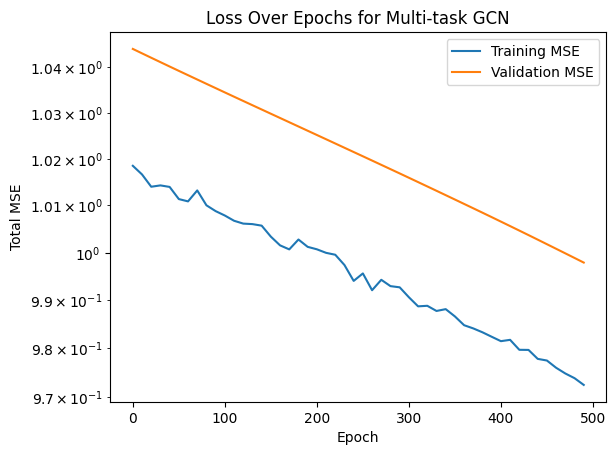

Best params: {'lr': 0.001, 'n_neurons': 128, 'dr': 0.3}
Best val loss: 0.6018373370170593


{'lr': 0.001, 'n_neurons': 128, 'dr': 0.3}

In [24]:
# hyperparameter tuning
My_Fit.hp_tuning(graph_data, X.shape[1])